In [2]:
import numpy as np
import casadi as ca
import math

In [18]:
NDIM  = 2
NPIECE = 2       # 5阶段轨迹曲线
S = 3       # jerk控制
POLY_RANK = 2*S-1
NCOFF  = 2*S
NCKPT  = 4

max_vel_sq = 2
max_acc_sq = 3
max_cur_sq = 0.5

weight_dt = 0.01

In [4]:
t = ca.SX.sym('t')

def constructBetaT(t, rank:int):
    ''' 构造特定时间的β(t) '''
    beta = ca.SX(NCOFF, 1)
    for i in range(rank, NCOFF):
        if not isinstance(t, int|float) or t!=0 or i-rank==0:
            beta[i] = math.factorial(i)/math.factorial(i-rank) * t**(i-rank)
    return beta

def constructEi(dT):
    ''' 构造M矩阵中的Ei(2s*2s)=[β(T), β(T), ..., β(T)^(2s-2)] '''
    Ei = ca.SX(NCOFF, NCOFF)
    Ei[0, :] = constructBetaT(dT, 0)
    for i in range(1, NCOFF):
        Ei[i, :] = constructBetaT(dT, i-1)
    return Ei

def constructFi():
    ''' 构造M矩阵中的Fi(2s*2s)=[0, -β(0), ..., β(0)^(2s-2)] '''
    Fi = ca.SX(NCOFF, NCOFF)
    for i in range(1, NCOFF):
        Fi[i, :] = -constructBetaT(0, i-1)
    return Fi

def constructF0():
    ''' 构造M矩阵中的F0(s*2s)=[β(0), ..., β(0)^(s-1)] '''
    F0 = ca.SX(S, NCOFF)      # 端点约束
    for i in range(S):
        F0[i, :] = constructBetaT(0, i)
    return F0

def constructEM(T):
    ''' 构造M矩阵中的E0(s*2s)=[β(T), ..., β(T)^(s-1)] '''
    E0 = ca.SX(S, NCOFF)      # 端点约束
    for i in range(S):
        E0[i, :] = constructBetaT(T, i)
    return E0

def constructM(dT, num_pieces):
    ''' 构造矩阵M=[
        [F0,    0,      0,      0,    ...,    ],
        [E1,   F1,      0,      0,    ...,    ],
        [ 0,   E2,     F2,      0,    ...,    ],
        ...
    ]
    '''
    M = ca.SX(num_pieces*NCOFF, num_pieces*NCOFF)
    M[0:S, 0:NCOFF] = constructF0()
    M[-S:, -NCOFF:] = constructEM(T=dT*num_pieces)
    for i in range(1, num_pieces):
        M[(i-1)*NCOFF+S:i*NCOFF+S, (i-1)*NCOFF:i*NCOFF] = constructEi(t)
        M[(i-1)*NCOFF+S:i*NCOFF+S, i*NCOFF:(i+1)*NCOFF] = constructFi()
    return M


def constructB(start_states, end_states, mid_pos, num_pieces):
    ''' 构造右端路径点约束B矩阵'''
    B = ca.SX(num_pieces*NCOFF, NDIM)
    B[0:S,:] = start_states                     # 起点状态
    B[-S:,:] = end_states                       # 终点状态
    for i in range(1, num_pieces):
        B[(i-1)*NCOFF+S, :] = mid_pos[i]      # 设置中间路径点
    return B


def constructBBTint(dT, rank):
    ''' c^T*(∫β*β^T*dt)*c ==> (2, NCOFF) * (NCOFF, NCOFF) * (NCOFF, 2) '''
    bbint = ca.SX(NCOFF, NCOFF)
    beta = constructBetaT(dT, rank)
    for i in range(NCOFF):
        for j in range(NCOFF):
            if i+j-2*rank < 0: continue
            coff = 1 / (i+j-2*rank+1)
            bbint[i, j] = coff * beta[i] * beta[j] * dT
    return bbint

def objectFunc(dT, start_states, end_states, mid_pos):
    ''' 代价函数 '''
    bbint = constructBBTint(dT, S)      # (ncoff * ncoff)
    M = constructM(dT=dT, num_pieces=NPIECE)
    B = constructB(start_states=start_states, end_states=end_states, mid_pos=mid_pos, num_pieces=NPIECE)
    c = ca.solve(M, B)

    # TODO. 每一条轨迹的代价
    cost =  0
    for j in range(NPIECE):
        cj = c[j*NCOFF:(j+1)*NCOFF]
        cost += ca.trace(cj.T @ bbint @ cj)
    cost += dT * NPIECE * weight_dt
    return cost


# ss = ca.SX.sym('ss', 3, 2)
# es = ca.SX.sym('es', 3, 2)
ss = ca.DM([[0,0],[0,0],[0,0]])
es = ca.DM([[1,0],[0,0],[0,0]])
mp = ca.SX.sym('mp', NPIECE-1, NDIM)
obj=objectFunc(t, ss, es, mp)



# print(objectFunc(t, 3))

# B=constructB(ss, es, mp, 1)
# M=constructM(t, 1)

# print(B)
# print(M)

In [19]:

def create_L1_function():
    a0 = 1e-3
    x = ca.SX.sym('x')

    f1 = 0  # x <= 0
    f2 = -1/(2*a0**3)*x**4 + 1/a0**2*x**3  # 0 < x <= a0
    f3 = x - a0/2  # a0 < x

    L1 = ca.if_else(x <= 0, f1,
         ca.if_else(x <= a0, f2, f3))

    L1_func = ca.Function('L1', [x], [L1])

    return L1_func

def create_T_function():
    tau = ca.SX.sym('tau')

    f1 = 0.5 * tau**2 + tau + 1  # tau > 0
    f2 = (tau**2 - 2*tau + 2)/2  # tau <= 0

    T = ca.if_else(tau > 0, f1, f2)

    T_func = ca.Function('T', [tau], [T])

    return T_func

L1slack = create_L1_function()
T_trans = create_T_function()

ckpt_frac = [(i+1)/(NCKPT+1) for i in range(NCKPT)]
T = ca.SX.sym('dT')
ckpt_ts = ckpt_frac * T


def constructCkptMat(ckpt_ts, rank:int):
    ''' 构造单个piece的CKPT检查矩阵 '''
    ckpt_mat = ca.SX.zeros(NCOFF, NCKPT)
    for i in range(NCKPT):
        ckpt_mat[:, i] = constructBetaT(t=ckpt_ts[i], rank=rank)
    return ckpt_mat

def constructNPiecesCkptMat(ckpt_ts, rank:int, num_pieces:int):
    ''' 构造整条轨迹的ckpt检查矩阵[NPIECE*NCOFF, NUM_CKPT] '''
    return ca.repmat(constructCkptMat(ckpt_ts=ckpt_ts, rank=rank), num_pieces, 1)


coff_mat = ca.SX.sym('coff', NPIECE*NCOFF, NDIM)
vel_ckm = constructNPiecesCkptMat(ckpt_ts=ckpt_ts, rank=1, num_pieces=NPIECE)
acc_ckm = constructNPiecesCkptMat(ckpt_ts=ckpt_ts, rank=2, num_pieces=NPIECE)

auxMat = ca.DM([[0,-1],[1,0]])

vels = vel_ckm.T @ coff_mat        # [NPIECE*NCOFF, NCKPT].T @ [NPIECE*NCOFF, NDIM] -> [NUM_CKPT, NDIM]
accs = acc_ckm.T @ coff_mat

vels_sqsum = ca.sum2(vels ** 2)
accs_sqsum = ca.sum2(accs ** 2)

curvature_num = ca.sum2((accs @ auxMat) * vels)
curvature_den = vels_sqsum ** 3
curvature_sq = curvature_num / curvature_den

con1 = L1slack(vels_sqsum - max_vel_sq)
con2 = L1slack(accs_sqsum - max_acc_sq)
con2 = L1slack(curvature_sq - max_cur_sq)


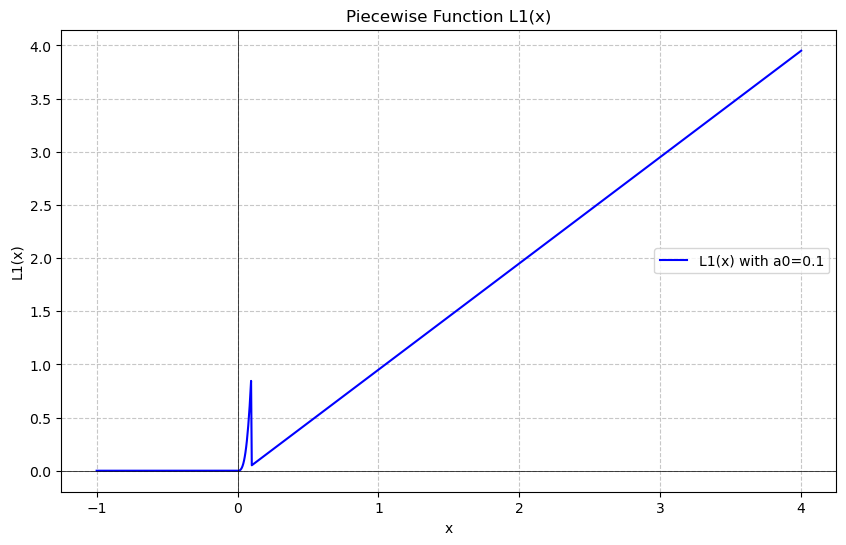

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def L1(x, a0):
    # 创建与x形状相同的零数组
    result = np.zeros_like(x)

    # x <= 0 的部分
    mask1 = x <= 0
    result[mask1] = 0

    # 0 < x <= a0 的部分
    mask2 = (x > 0) & (x <= a0)
    result[mask2] = -1/(2*a0**3) * x[mask2]**4 + 1/a0**3 * x[mask2]**3

    # x > a0 的部分
    mask3 = x > a0
    result[mask3] = x[mask3] - a0/2

    return result

# 生成x轴数据点
a0 = 1e-1  # 设定a0的值
x = np.linspace(-1, 4, 1000)  # 从-1到4生成1000个点

# 计算对应的y值
y = L1(x, a0)

# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', label=f'L1(x) with a0={a0}')

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

# 添加坐标轴
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

# 设置标签和标题
plt.xlabel('x')
plt.ylabel('L1(x)')
plt.title('Piecewise Function L1(x)')
plt.legend()

# 显示图形
plt.show()